<a href="https://colab.research.google.com/github/AnsiaNijas/MLNN_Tutorials/blob/main/sentiment_analysis_glove_bilstm_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center;">
    <h1><b>Sentiment Analysis with Pretrained GloVe Embeddings and Bidirectional LSTM on the IMDB Dataset</b></h1>
  


## **Introduction**

Sentiment analysis is a natural language processing (NLP) task used to determine whether a piece of text expresses a positive, negative, or neutral sentiment. It is widely used in applications like analyzing customer feedback and understanding public opinion on social media.

In this tutorial, we will perform sentiment analysis on the IMDB dataset using a Bidirectional LSTM model combined with pretrained GloVe embeddings. GloVe embeddings provide pre-trained word representations, helping the model understand the meaning of words effectively. I will walk through the entire process, from preparing the dataset to building and evaluating the model.



## **Dataset Overview**

### **IMDB Dataset**
The IMDB dataset is a standard benchmark for sentiment analysis. It consists of 50,000 movie reviews:
- **25,000 reviews for training** and **25,000 reviews for testing**.
- Each review is labeled as either positive (1) or negative (0), making this a binary classification task.




## **Model Architecture**

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/AnsiaNijas/MLNN_Tutorials/main/sentiment_analysis_flowchart.png"
         alt="A visual representation of the model architecture for sentiment analysis using GloVe embeddings and BiLSTM. It includes layers such as GloVe embedding, Bidirectional LSTM, Dense, Dropout, and Output with sigmoid activation."
         style="width: 70%; height: auto;">
    <p><em>Figure 1: Model Architecture - GloVe Embeddings and BiLSTM for Sentiment Analysis.</em></p>
    <p style="font-size: 12px; color: grey;"><em>Alt Text: A visual representation of the model architecture for sentiment analysis using GloVe embeddings and BiLSTM. It includes layers such as GloVe embedding, Bidirectional LSTM, Dense, Dropout, and Output with sigmoid activation.</em></p>
</div>


### **The Model Architecture**

This model combines pretrained GloVe embeddings with a Bidirectional LSTM network for sentiment analysis.

- #### **Pretrained GloVe Embeddings**
The embedding layer uses GloVe embeddings to convert words into dense vectors that capture semantic relationships. The embedding matrix maps each word in the dataset to its GloVe vector, while being frozen (`trainable=False`) to preserve pre-trained knowledge.(Wu et al., 2023.).

- #### **Bidirectional LSTM Layer**
A Bidirectional LSTM with 64 units processes sequences in both forward and backward directions, capturing context from both ends of a sentence.(Aburass et al., 2023).

- #### **Dense and Dropout Layers**
A dense layer with 64 units and ReLU activation extracts features, while a 50% dropout rate prevents overfitting. The output layer, with a single neuron and sigmoid activation, predicts the sentiment as a probability.

This architecture combines GloVe embeddings and LSTMs for effective sentiment analysis.

## **Code Walkthrough**
### **Setup: Preparing the Environment**

In this step, we prepare the environment by importing the necessary libraries and dependencies required for the tutorial. By importing these libraries, we set up the foundational tools needed to complete the rest of the tutorial, such as data preparation, model building, training, and evaluation.



In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Next, I will set random seeds for reproducibility. This step ensures that the results remain consistent across multiple runs of the code, which is essential for reliable experimentation and debugging.

In [ ]:
# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## **Load the IMDB Dataset**
This step uses TensorFlow Datasets (tfds) to load the IMDB dataset, which contains 50,000 movie reviews labeled as positive or negative. The tfds.load() function splits the dataset into training and testing sets, prepares the data as input-label pairs, and provides metadata for reference.

This prepares the data for preprocessing in the next step.

In [ ]:
# Load IMDB dataset
(train_data, test_data), info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

## **Exploring the IMDB Dataset**
Let's explore the IMDB dataset to understand its structure and content. After loading the dataset, exploring it is a crucial step to ensure we are familiar with the data format, features, and labels. This will help us prepare the data effectively for modeling.

In [ ]:
# Check the dataset metadata
print(info)

# Display a few examples from the training data
for text, label in train_data.take(3):
    print(f"Review: {text.numpy().decode('utf-8')}")
    print(f"Label: {label.numpy()}\n")

# Count the number of examples in the training and testing sets
train_count = len(list(train_data))
test_count = len(list(test_data))
print(f"Number of training examples: {train_count}")
print(f"Number of testing examples: {test_count}")


tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
    

## **Preprocess the Data**
Now that we’ve loaded the dataset, let’s extract the sentences (reviews) and their corresponding labels to prepare the data for further processing. This step ensures the data is in a structured format that the model can understand.

In [ ]:
# Extract sentences and labels
train_sentences, train_labels = [], []
test_sentences, test_labels = [], []

for s, l in train_data:
    train_sentences.append(s.numpy().decode('utf8'))
    train_labels.append(l.numpy())

for s, l in test_data:
    test_sentences.append(s.numpy().decode('utf8'))
    test_labels.append(l.numpy())

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

#### **What’s Happening Here?**
- **Extracting Sentences**:  
  We iterate through the training and testing datasets to extract the movie reviews. Each review, initially stored as a tensor, is converted to plain text using `.numpy().decode('utf8')`.

- **Extracting Labels**:  
  Alongside the reviews, we extract the sentiment labels. Labels are integers, where `0` indicates a negative review and `1` indicates a positive review.

- **Converting Labels to Arrays**:  
  Finally, the labels are converted into numpy arrays. This makes them compatible with the machine learning tools we’ll use later.

Let’s move on to the next step, where we tokenize and prepare the text for the model!

## **Tokenize and Pad Sequences**
In this step, we process the text data into a numerical format that the machine learning model can understand. This involves tokenizing the text into sequences of integers and then padding these sequences to ensure uniform input length.

In [ ]:
# Parameters
vocab_size = 20000
embedding_dim = 100
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## **Load Pretrained GloVe Embeddings**
Now that we have tokenized and padded the text data, let’s bring in pre-trained GloVe embeddings to add semantic meaning to our words. These embeddings are widely used in NLP tasks because they capture relationships between words based on their co-occurrence in large corpora.

#### **What’s Happening Here?**
**Downloading GloVe Embeddings**:

First, we download the GloVe embeddings file from Stanford’s repository. This file contains pre-trained word vectors for a vocabulary of words

In [ ]:
# Check if the GloVe embeddings are already downloaded
if not os.path.exists('./glove.6B/glove.6B.100d.txt'):
    print("GloVe embeddings not found. Downloading...")
     # Download GloVe embeddings
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip -d ./glove.6B/
else:
    print("GloVe embeddings already exist. Skipping download.")

GloVe embeddings already exist. Skipping download.


**Loading Embeddings:**

Next, we load these embeddings into a Python dictionary. In this dictionary:
Each key is a word from the vocabulary.
Each value is a vector representing the semantic meaning of the word.

In [ ]:
# Load embeddings into a dictionary
embeddings_index = {}
with open('./glove.6B/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

#### **Why Are We Doing This?**
GloVe embeddings capture the relationships and similarities between words, such as synonyms or words used in similar contexts. By using these pre-trained embeddings, the model starts with a strong understanding of word meanings without needing to learn them from scratch. This significantly improves the model's performance, especially when working with smaller datasets, as it improves knowledge from large, pre-trained corpora.

With the embeddings loaded, we are now ready to integrate them into the model architecture to enhance its understanding of semantic relationships! Let’s proceed to the next step.

## **Create Embedding Matrix**
Now that we’ve loaded the GloVe embeddings, let’s create an embedding matrix that will map the words in our dataset to their corresponding GloVe vectors. This matrix will serve as the foundation for the embedding layer in our model.

In [ ]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

This embedding matrix is now ready to be integrated into the embedding layer of our model. Let’s proceed to build the model!

## **Building the Model**

Now, let’s build a model for sentiment analysis that incorporates GloVe embeddings, a Bidirectional LSTM layer, and dense layers for binary classification.

---

#### **What Are We Doing?**
We are creating a structured architecture with the following components:

1. **Embedding Layer**:
   - Integrates the pretrained GloVe embedding matrix to represent words as dense vectors.
   - Set to `trainable=False` to keep the pretrained embeddings unchanged during training.

2. **Bidirectional LSTM**:
   - Processes sequences in both forward and backward directions, enhancing the model’s ability to capture context.
   - Includes 64 units to learn long-term dependencies in the text.

3. **Dense Layer**:
   - A fully connected layer with 64 units and ReLU activation, responsible for extracting high-level features from the LSTM output.

4. **Dropout Layer**:
   - Applies a 50% dropout rate to prevent overfitting by disabling random neurons during training.

5. **Output Layer**:
   - A single neuron with sigmoid activation outputs a probability for binary classification, determining the sentiment as positive or negative.

This model combines the power of GloVe embeddings with LSTM’s sequential processing capabilities to create an effective solution for sentiment analysis.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.build(input_shape=(None, max_length))  # Specify the input shape



Now that we’ve built the model, let’s print the model summary to understand its structure and the number of parameters.

In [ ]:
# Model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,092,801 (7.98 MB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

## **Compile the Model**
After building the model, the next step is to compile it. Compiling the model sets up the loss function, optimizer, and evaluation metrics, which define how the model learns and measures its performance.

Compiling the model involves defining key components that guide its learning process. First, we set the loss function to binary_crossentropy, which measures the difference between the predicted and actual labels for our binary classification task. Next, we choose the optimizer, adam, to adjust the model’s weights efficiently during training and minimize the loss. Finally, we specify accuracy as the evaluation metric, allowing us to monitor how often the model correctly predicts the sentiment.

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


## **Adding Callbacks**

In this step, we introduce two essential callbacks, **`EarlyStopping`** and **`ReduceLROnPlateau`**, to enhance the training process by monitoring model performance and dynamically adjusting the learning rate. **`EarlyStopping`** halts training when validation loss stops improving and restores the best model weights, while **`ReduceLROnPlateau`** reduces the learning rate if progress stagnates. Together, these callbacks improve training efficiency and help prevent overfitting. Let’s integrate them into the process!

In [ ]:
#Add Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

## **Train the Model**

Let’s train the model to learn the patterns in the data. We provide the training data and labels so the model can understand how to classify sentiments. We also use validation data to monitor its performance on unseen data during training. By repeating the process for 10 epochs, the model gradually improves its accuracy. After training, the model will be ready for evaluation and predictions!

In [ ]:
# Train the model
num_epochs = 40
history = model.fit(
    train_padded,
    train_labels,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.2,
    validation_data=(test_padded, test_labels),
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

Epoch 1/40
391/391 - 159s - 405ms/step - accuracy: 0.6815 - loss: 0.5881 - val_accuracy: 0.7562 - val_loss: 0.5014 - learning_rate: 0.0010
Epoch 2/40
391/391 - 201s - 514ms/step - accuracy: 0.7739 - loss: 0.4813 - val_accuracy: 0.7850 - val_loss: 0.4570 - learning_rate: 0.0010
Epoch 3/40
391/391 - 201s - 514ms/step - accuracy: 0.7935 - loss: 0.4443 - val_accuracy: 0.7962 - val_loss: 0.4339 - learning_rate: 0.0010
Epoch 4/40
391/391 - 150s - 384ms/step - accuracy: 0.8106 - loss: 0.4158 - val_accuracy: 0.8043 - val_loss: 0.4210 - learning_rate: 0.0010
Epoch 5/40
391/391 - 240s - 614ms/step - accuracy: 0.8234 - loss: 0.3907 - val_accuracy: 0.8086 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 6/40
391/391 - 200s - 511ms/step - accuracy: 0.8339 - loss: 0.3704 - val_accuracy: 0.8088 - val_loss: 0.4127 - learning_rate: 0.0010
Epoch 7/40
391/391 - 198s - 506ms/step - accuracy: 0.8451 - loss: 0.3483 - val_accuracy: 0.8087 - val_loss: 0.4150 - learning_rate: 0.0010
Epoch 8/40
391/391 - 203s -

## **Evaluate the Model**

Let’s evaluate the model to see how well it performs on unseen data. We use the test dataset to calculate the accuracy and loss, which give us an idea of the model’s overall effectiveness. This step helps us understand how well the model can generalize to new inputs. Let’s check the test accuracy to assess our model’s performance!

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f'Test Accuracy: {accuracy:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.8092 - loss: 0.4149
Test Accuracy: 0.8088


## **Save the Model**

Let’s save the trained model so we can reuse it later for predictions or further analysis without retraining. This ensures we preserve all the progress made during training and makes the model ready for deployment or sharing!

In [ ]:
# Save the model
model.save('sentiment_analysis_glove_bilstm.h5')

Let’s plot training and validation accuracy and loss to evaluate the model’s learning and generalization. Accuracy reflects pattern recognition, while loss measures error minimization. By extracting metrics such as `history.history['accuracy']`, `history.history['val_accuracy']`, `history.history['loss']`, and `history.history['val_loss']`, we can analyze performance trends over epochs. These visualizations help identify overfitting, underfitting, and areas for improvement, ensuring the model’s effectiveness.

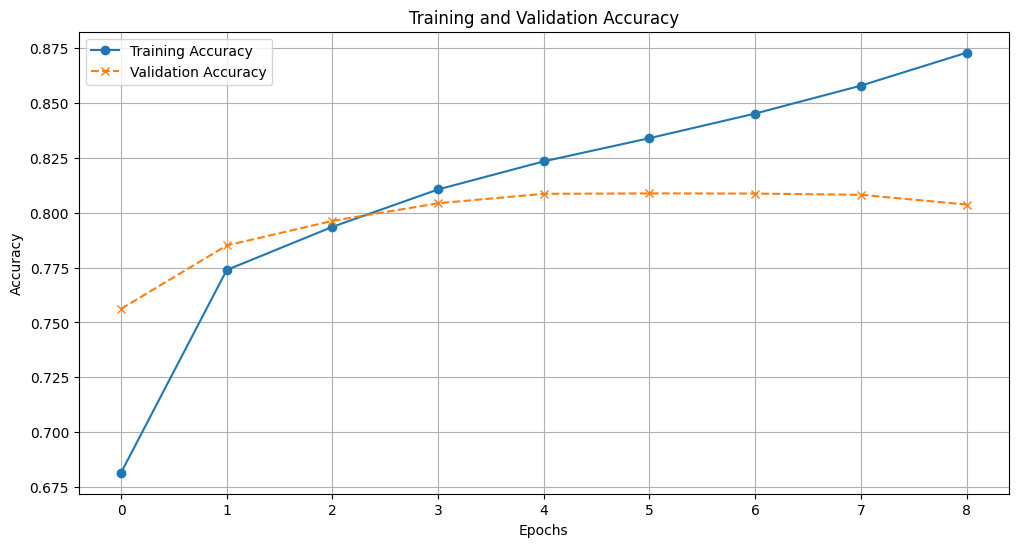

Alt Text: A line plot showing Training and Validation Accuracy over 9 epochs. The x-axis represents the number of epochs, ranging from 0 to 8, while the y-axis represents accuracy, ranging from 0.675 to 0.875. The training accuracy is depicted with a solid blue line and circular markers, showing a steady increase across epochs. The validation accuracy is shown with a dashed orange line and cross markers, increasing initially but plateauing and slightly declining towards the later epochs. The graph includes a legend indicating 'Training Accuracy' and 'Validation Accuracy'.


In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='solid', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.grid(True)  # Add grid lines for better readability
plt.show()
alt_text="A line plot showing Training and Validation Accuracy over 9 epochs. The x-axis represents the number of epochs, ranging from 0 to 8, while the y-axis represents accuracy, ranging from 0.675 to 0.875. The training accuracy is depicted with a solid blue line and circular markers, showing a steady increase across epochs. The validation accuracy is shown with a dashed orange line and cross markers, increasing initially but plateauing and slightly declining towards the later epochs. The graph includes a legend indicating 'Training Accuracy' and 'Validation Accuracy'."
print(f"Alt Text: {alt_text}")

In this plot, the circular markers represent the training accuracy, while the dashed lines with cross markers represent the validation accuracy.

The training accuracy steadily increases with each epoch, showing that the model is learning and fitting the training data well. The validation accuracy also improves initially but plateaus after a few epochs, indicating that the model has reached its optimal performance on unseen data. Since early stopping was used, the training was automatically halted once the validation accuracy stopped improving, preventing the model from overfitting to the training data.


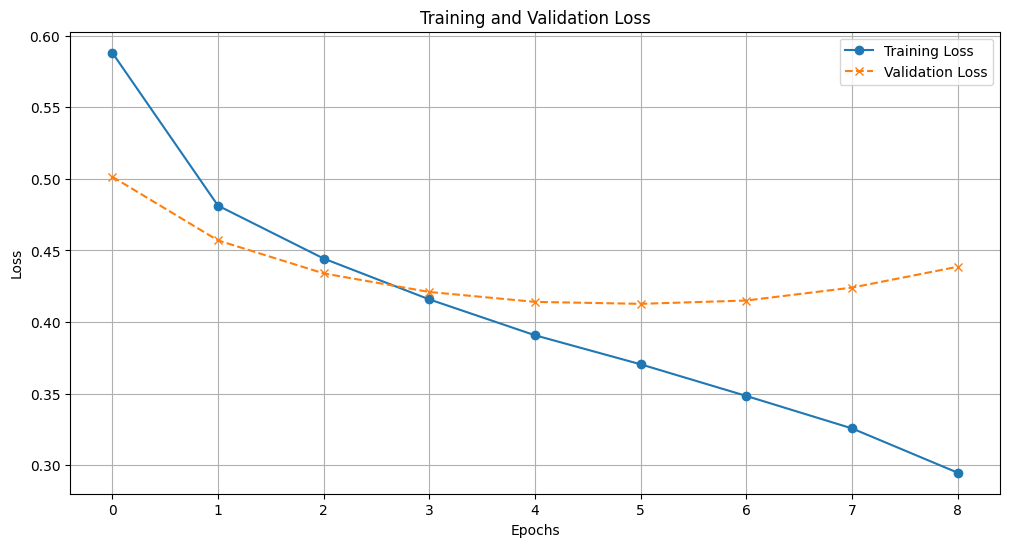

Alt Text: A line plot showing the Training and Validation Loss over 9 epochs. The x-axis represents the number of epochs, ranging from 0 to 8, and the y-axis represents the loss, ranging from 0.3 to 0.6. The training loss is depicted with a solid blue line and circular markers, showing a consistent decrease across all epochs. The validation loss is represented with a dashed orange line and cross markers, initially decreasing and then slightly increasing in later epochs. The graph includes a legend indicating 'Training Loss' and 'Validation Loss.


In [ ]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='solid', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.grid(True)  # Add grid lines for better readability
plt.show()
# Provide the alt text as a printed description
alt_text = "A line plot showing the Training and Validation Loss over 9 epochs. The x-axis represents the number of epochs, ranging from 0 to 8, and the y-axis represents the loss, ranging from 0.3 to 0.6. The training loss is depicted with a solid blue line and circular markers, showing a consistent decrease across all epochs. The validation loss is represented with a dashed orange line and cross markers, initially decreasing and then slightly increasing in later epochs. The graph includes a legend indicating 'Training Loss' and 'Validation Loss."
print(f"Alt Text: {alt_text}")

In this plot, the circular markers represent the training loss, while the dashed lines with cross markers represent the validation loss over the epochs.

The training loss decreases steadily across all epochs, which is expected as the model optimizes its weights to minimize errors on the training data. On the other hand, the validation loss initially decreases but begins to increase after a few epochs. This suggests that while the model is improving its performance on the training data, it starts to overfit, performing worse on unseen data after a certain point.

Since early stopping was applied, the training automatically stopped after identifying the optimal point where the validation loss started to increase. This ensures the model achieves the best possible performance without overfitting to the training data.



## **Load and Use the Model**
Let’s load the saved model and use it to predict sentiment for new text data. First, we load the model from the saved file. Then, we process the new input text by tokenizing and padding it, just like we did during training. Finally, we pass the prepared data to the model for prediction, where the output indicates the sentiment: closer to 1 for positive and closer to 0 for negative.

This step shows how to apply the trained model to real-world scenarios!

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model('sentiment_analysis_glove_bilstm.h5')

# Predict on new data
sample_text = ["The movie was fantastic! I really enjoyed it."]
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
prediction = loaded_model.predict(sample_padded)
print(f'Prediction: {prediction[0][0]:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Prediction: 0.9866


## **Conclusion and Future Directions**

This tutorial demonstrated the use of BiLSTM with pretrained GloVe embeddings for sentiment analysis, effectively capturing contextual relationships for accurate predictions. However, performance depends on the quality and domain of input data.

To improve, consider dynamic hyperparameter tuning with tools like Optuna and integrating ensemble models like BiLSTM with BERT. Apply data augmentation techniques, such as back-translation, to enhance generalization. Use tools like LIME or SHAP for better interpretability and insights. Finally, prepare the model for deployment by converting it to TensorFlow Lite or ONNX for use in mobile or web applications.





## GitHub Repository
You can find the source code and updates for this tutorial on GitHub:
[MLNN GitHub Repository](https://github.com/AnsiaNijas/MLNN_Tutorials)

You can execute the code in Google Colab using the following link: [Sentiment Analysis using GloVe and BiLSTM on IMDb Dataset](https://colab.research.google.com/github/AnsiaNijas/MLNN_Tutorials/blob/main/sentiment_analysis_glove_bilstm_imdb.ipynb).



## References

- Aburass, S., Dorgham, O., & Al Shaqsi, J., 2023. A Hybrid Machine Learning Model for Classifying Gene Mutations in Cancer Using LSTM, BiLSTM, CNN, GRU, and GloVe. arXiv. Available at: https://arxiv.org/abs/2307.14361 [Accessed 12 Dec. 2024].
- Keras, 2023. Available at: [https://keras.io/](https://keras.io/) [Accessed 5 Dec. 2024].
- TensorFlow, 2023. Available at: [https://www.tensorflow.org/](https://www.tensorflow.org/) [Accessed 2 Dec. 2024].
- Wu, J., Ren, P., Song, B., Zhang, R., Zhao, C., & Zhang, X., 2023. Data Glove-Based Gesture Recognition Using CNN-BiLSTM Model with Attention Mechanism. PLOS ONE. Available at: https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0294174 [Accessed 12 Dec. 2024].



---
<div style="text-align: center; font-size: 0.9em; color: grey; margin-top: 20px;">
    This tutorial is licensed under the <a href="https://github.com/AnsiaNijas/MLNN_Tutorials/blob/main/LICENSE" target="_blank">MIT License</a>.
</div>